<a href="https://colab.research.google.com/github/teruto725/recognize_num/blob/master/num_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##数字認識NNを作る
sktlearnよりMNISデータを読み込み、Chainerで作成したNNに投げ、結果を出力するとともに、学習したNNをnum_pic.netとして保存する
1. データセット    
MNIST
2. 最適化手法  
確率的勾配降下法
3. 目的関数  
交差エントロピー
4. 活性化関数  
ReLU関数
5. ニューラルネットワーク
入力724 出力10 3層　中間層の数 1000


In [0]:
from chainer import Link, Chain, ChainList
import chainer
import chainer.functions as F
import chainer.links as L
from shutil import copyfileobj
from six.moves import urllib
from sklearn.datasets.base import get_data_home
import matplotlib.pyplot as plot
import numpy as np
import os

In [0]:
import google.colab.drive
google.colab.drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
from sklearn.datasets import fetch_mldata
from shutil import copyfileobj
from six.moves import urllib
from sklearn.datasets.base import get_data_home
import os

#mnist = fetch_mldata('MNIST original', data_home=".")
#このコードでエラーが出る場合は，以下を実行．

def fetch_mnist(data_home=None):
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    data_home = get_data_home(data_home=data_home)
    data_home = os.path.join(data_home, 'mldata')
    if not os.path.exists(data_home):
        os.makedirs(data_home)
    mnist_save_path = os.path.join(data_home, "mnist-original.mat")
    if not os.path.exists(mnist_save_path):
        mnist_url = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_save_path, "wb") as matlab_file:
            copyfileobj(mnist_url, matlab_file)

fetch_mnist()
mnist = fetch_mldata('MNIST original')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
x   = mnist.data.astype(np.float32)#入力値
x  /= 255     # 0-1のデータに変換
t = mnist.target.astype(np.int32)#目標値

In [0]:
from sklearn.model_selection import train_test_split
#データセットの分割
x_train_val, x_test, t_train_val, t_test = train_test_split(x, t, test_size=0.3, random_state=0)
x_train, x_val, t_train, t_val = train_test_split(x_train_val, t_train_val, test_size=0.3, random_state=0)
print(np.shape(x_train))
#print(np.shape(x_val))
print(np.shape(x_test))

(34300, 784)
(21000, 784)


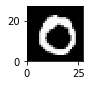

0.0


In [0]:
def draw_digit(data):
    size = 28
    plot.figure(figsize=(1, 1))

    X, Y = np.meshgrid(range(size),range(size))
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plot.xlim(0,27)
    plot.ylim(0,27)
    plot.pcolor(X, Y, Z)
    plot.gray()
    plot.tick_params(labelbottom="off")
    plot.tick_params(labelleft="off")

    plot.show()

draw_digit(mnist.data[5])
print(mnist.target[5])


In [0]:
from chainer import Sequential
# 入力 784次元、出力 10次元
# 中間層の数
n_units   = 1000
net = Sequential(L.Linear(784, n_units),F.relu,
                    L.Linear(n_units, n_units),F.relu,
                    L.Linear(n_units, 10))

In [0]:
optimizer = chainer.optimizers.SGD(lr=0.01)

optimizer.setup(net)

In [0]:
n_epoch = 20
n_batchsize = 100

In [0]:

iteration = 0

# ログの保存用
results_train = {
    'loss': [],
    'accuracy': []
}
results_valid = {
    'loss': [],
    'accuracy': []
}


for epoch in range(n_epoch):

    # データセット並べ替えた順番を取得
    order = np.random.permutation(range(len(x_train)))

    # 各バッチ毎の目的関数の出力と分類精度の保存用
    loss_list = []
    accuracy_list = []

    for i in range(0, len(order), n_batchsize):
        # バッチを準備
        index = order[i:i+n_batchsize]
        x_train_batch = x_train[index,:]
        t_train_batch = t_train[index]

        # 予測値を出力
        y_train_batch = net(x_train_batch)

        # 目的関数を適用し、分類精度を計算
        loss_train_batch = F.softmax_cross_entropy(y_train_batch, t_train_batch)
        accuracy_train_batch = F.accuracy(y_train_batch, t_train_batch)

        loss_list.append(loss_train_batch.array)
        accuracy_list.append(accuracy_train_batch.array)

        # 勾配のリセットと勾配の計算
        net.cleargrads()
        loss_train_batch.backward()

        # パラメータの更新
        optimizer.update()

        # カウントアップ
        iteration += 1

    # 訓練データに対する目的関数の出力と分類精度を集計
    loss_train = np.mean(loss_list)
    accuracy_train = np.mean(accuracy_list)

    # 1エポック終えたら、検証データで評価
    # 検証データで予測値を出力
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        y_val = net(x_val)

    # 目的関数を適用し、分類精度を計算
    loss_val = F.softmax_cross_entropy(y_val, t_val)
    accuracy_val = F.accuracy(y_val, t_val)

    # 結果の表示
    print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}'.format(
        epoch, iteration, loss_train, loss_val.array))

    # ログを保存
    results_train['loss'] .append(loss_train)
    results_train['accuracy'] .append(accuracy_train)
    results_valid['loss'].append(loss_val.array)
    results_valid['accuracy'].append(accuracy_val.array)

epoch: 0, iteration: 343, loss (train): 1.3864, loss (valid): 0.7313
epoch: 1, iteration: 686, loss (train): 0.5677, loss (valid): 0.4637
epoch: 2, iteration: 1029, loss (train): 0.4189, loss (valid): 0.3834
epoch: 3, iteration: 1372, loss (train): 0.3610, loss (valid): 0.3475
epoch: 4, iteration: 1715, loss (train): 0.3283, loss (valid): 0.3207
epoch: 5, iteration: 2058, loss (train): 0.3054, loss (valid): 0.3021
epoch: 6, iteration: 2401, loss (train): 0.2880, loss (valid): 0.2878
epoch: 7, iteration: 2744, loss (train): 0.2738, loss (valid): 0.2760
epoch: 8, iteration: 3087, loss (train): 0.2612, loss (valid): 0.2670
epoch: 9, iteration: 3430, loss (train): 0.2504, loss (valid): 0.2553
epoch: 10, iteration: 3773, loss (train): 0.2402, loss (valid): 0.2477
epoch: 11, iteration: 4116, loss (train): 0.2316, loss (valid): 0.2386
epoch: 12, iteration: 4459, loss (train): 0.2231, loss (valid): 0.2315
epoch: 13, iteration: 4802, loss (train): 0.2153, loss (valid): 0.2261
epoch: 14, iterati

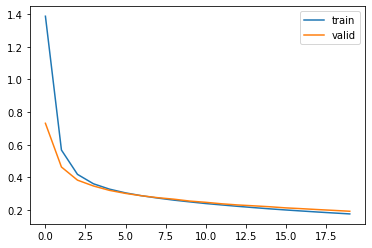

In [0]:

# 目的関数の出力 (loss)
plot.plot(results_train['loss'], label='train')  # label で凡例の設定
plot.plot(results_valid['loss'], label='valid')  # label で凡例の設定
plot.legend()  # 凡例の表示

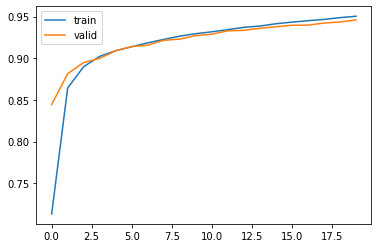

In [0]:

# 分類精度 (accuracy)
plot.plot(results_train['accuracy'], label='train')  # label で凡例の設定
plot.plot(results_valid['accuracy'], label='valid')  # label で凡例の設定
plot.legend()  # 凡例の表示

In [0]:
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = net(x_test)

In [0]:
accuracy_test = F.accuracy(y_test, t_test)
accuracy_test.array

array(0.9435238, dtype=float32)

In [0]:
chainer.serializers.save_npz('num_pic.net', net)

In [0]:
ls

num_pic.net  sample_data/


In [0]:
loaded_net = Sequential(L.Linear(784, n_units),F.relu,
                    L.Linear(n_units, n_units),F.relu,
                    L.Linear(n_units, 10))

In [0]:
chainer.serializers.load_npz('num_pic.net', loaded_net)

In [0]:
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = loaded_net(x_test)
y_test

variable([[ -4.313723  ,   7.0225916 ,   1.3074135 , ...,   1.4719822 ,
             0.12277101,  -1.9890753 ],
          [ -2.887788  , -10.144709  ,  -1.5012285 , ...,   1.4859335 ,
             1.8132539 ,   9.049821  ],
          [ -5.956624  ,   2.8602147 ,   9.374318  , ...,   3.376083  ,
             0.6507863 ,  -3.7095132 ],
          ...,
          [ -5.0707216 ,   7.8461747 ,   1.6084187 , ...,   0.5359857 ,
             1.2886262 ,  -2.0945163 ],
          [ -3.8224885 ,  -2.4017909 ,  -0.7819161 , ...,   0.25005022,
             1.1794322 ,   3.451763  ],
          [ -3.724019  ,   0.44527   ,   2.4330702 , ...,  -1.5249478 ,
             2.2242007 ,   0.25903794]])

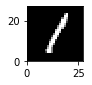

1


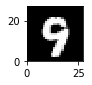

9


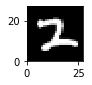

2


In [0]:
for i in range(3):
  draw_digit(x_test[i])
  print(np.argmax(y_test[i,:].array))

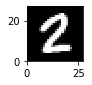

8


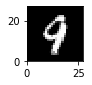

4


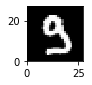

3


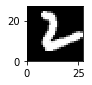

6


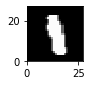

8


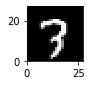

7


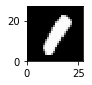

8


In [0]:
for i in range(100):
  if t_test[i] != np.argmax(y_test[i,:].array):
    draw_digit(x_test[i])  
    print(np.argmax(y_test[i,:].array))

#結果
いい感じに分類できた